In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

house_df =pd.read_csv('data/house_price.csv')
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# 데이터 사전 처리

In [75]:
print(house_df.shape) 
print(house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print(isnull_series[isnull_series > 0].sort_values(ascending=False))


(1460, 81)
object     43
int64      35
float64     3
dtype: int64
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


- 1000개 이상의 Null 값 들어있는 피처 드롭
- 회귀 모델 적용 - 분포도 정규 분포도 확인

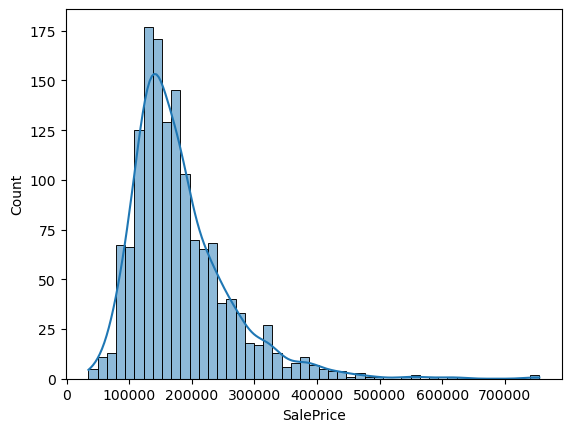

In [76]:
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

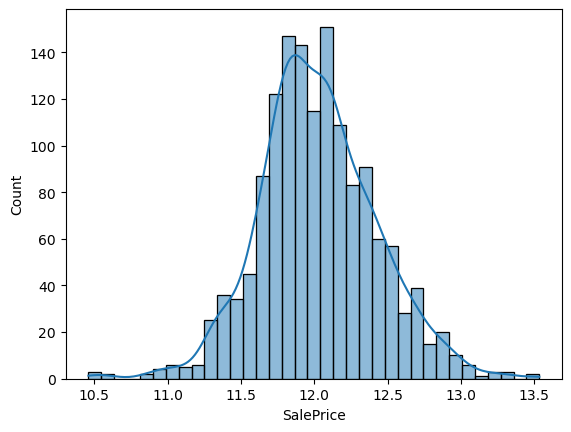

In [77]:
# 정규 분포 형태로 변환 - 로그 변환 log1p()
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)

In [78]:
#SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 값 많은, 불필요한 컬럭 삭제
house_df.drop(['Id','PoolQC', 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null 컬럼 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값 있는 피처명 타입 추출

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
house_df.dtypes[null_column_count.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [99]:
# 문자형 피처에만 Null 값 존재
# 문자형 피처 원-핫 인코딩 변환 : get_dummies()    Null->0

In [80]:

print(house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print(house_df_ohe.shape)

null_column_ohe_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
house_df.dtypes[null_column_ohe_count.index] 

(1460, 75)
(1460, 271)


MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

- 피처 증가 75 -> 271
- Null 값 없음

# 선형 회귀 모델 학습/예측/평가

-원래는 RMSLE (실제 값 예측값 오류를 로그 변환 후 RMSE 적용)로 진행 \
-SalePrice 이미 로그 변환 진행 완료 , RMSE로 진행

-여러 모델의 로그 변환된 RMSE 측정 위한 계산 함수 만들기 \
-단일 모델의 RMSE 값을 여러 모델의 RMSE 값으로 반환하기

In [82]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__ , np.round(rmse,3))
    return rmse

In [83]:
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses


In [103]:
# 선형 회귀 모델 학습/예측/평가

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train,X_test,y_train,y_test =train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression Ridge Lasso
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 0.128
Ridge 0.125
Lasso 0.247


[0.1282603705874917, 0.1246976252628146, 0.24683793626604372]

In [85]:
# 피처별 회귀 계수 시각화

In [86]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

In [87]:
# 모델별 회귀 계수 시각화

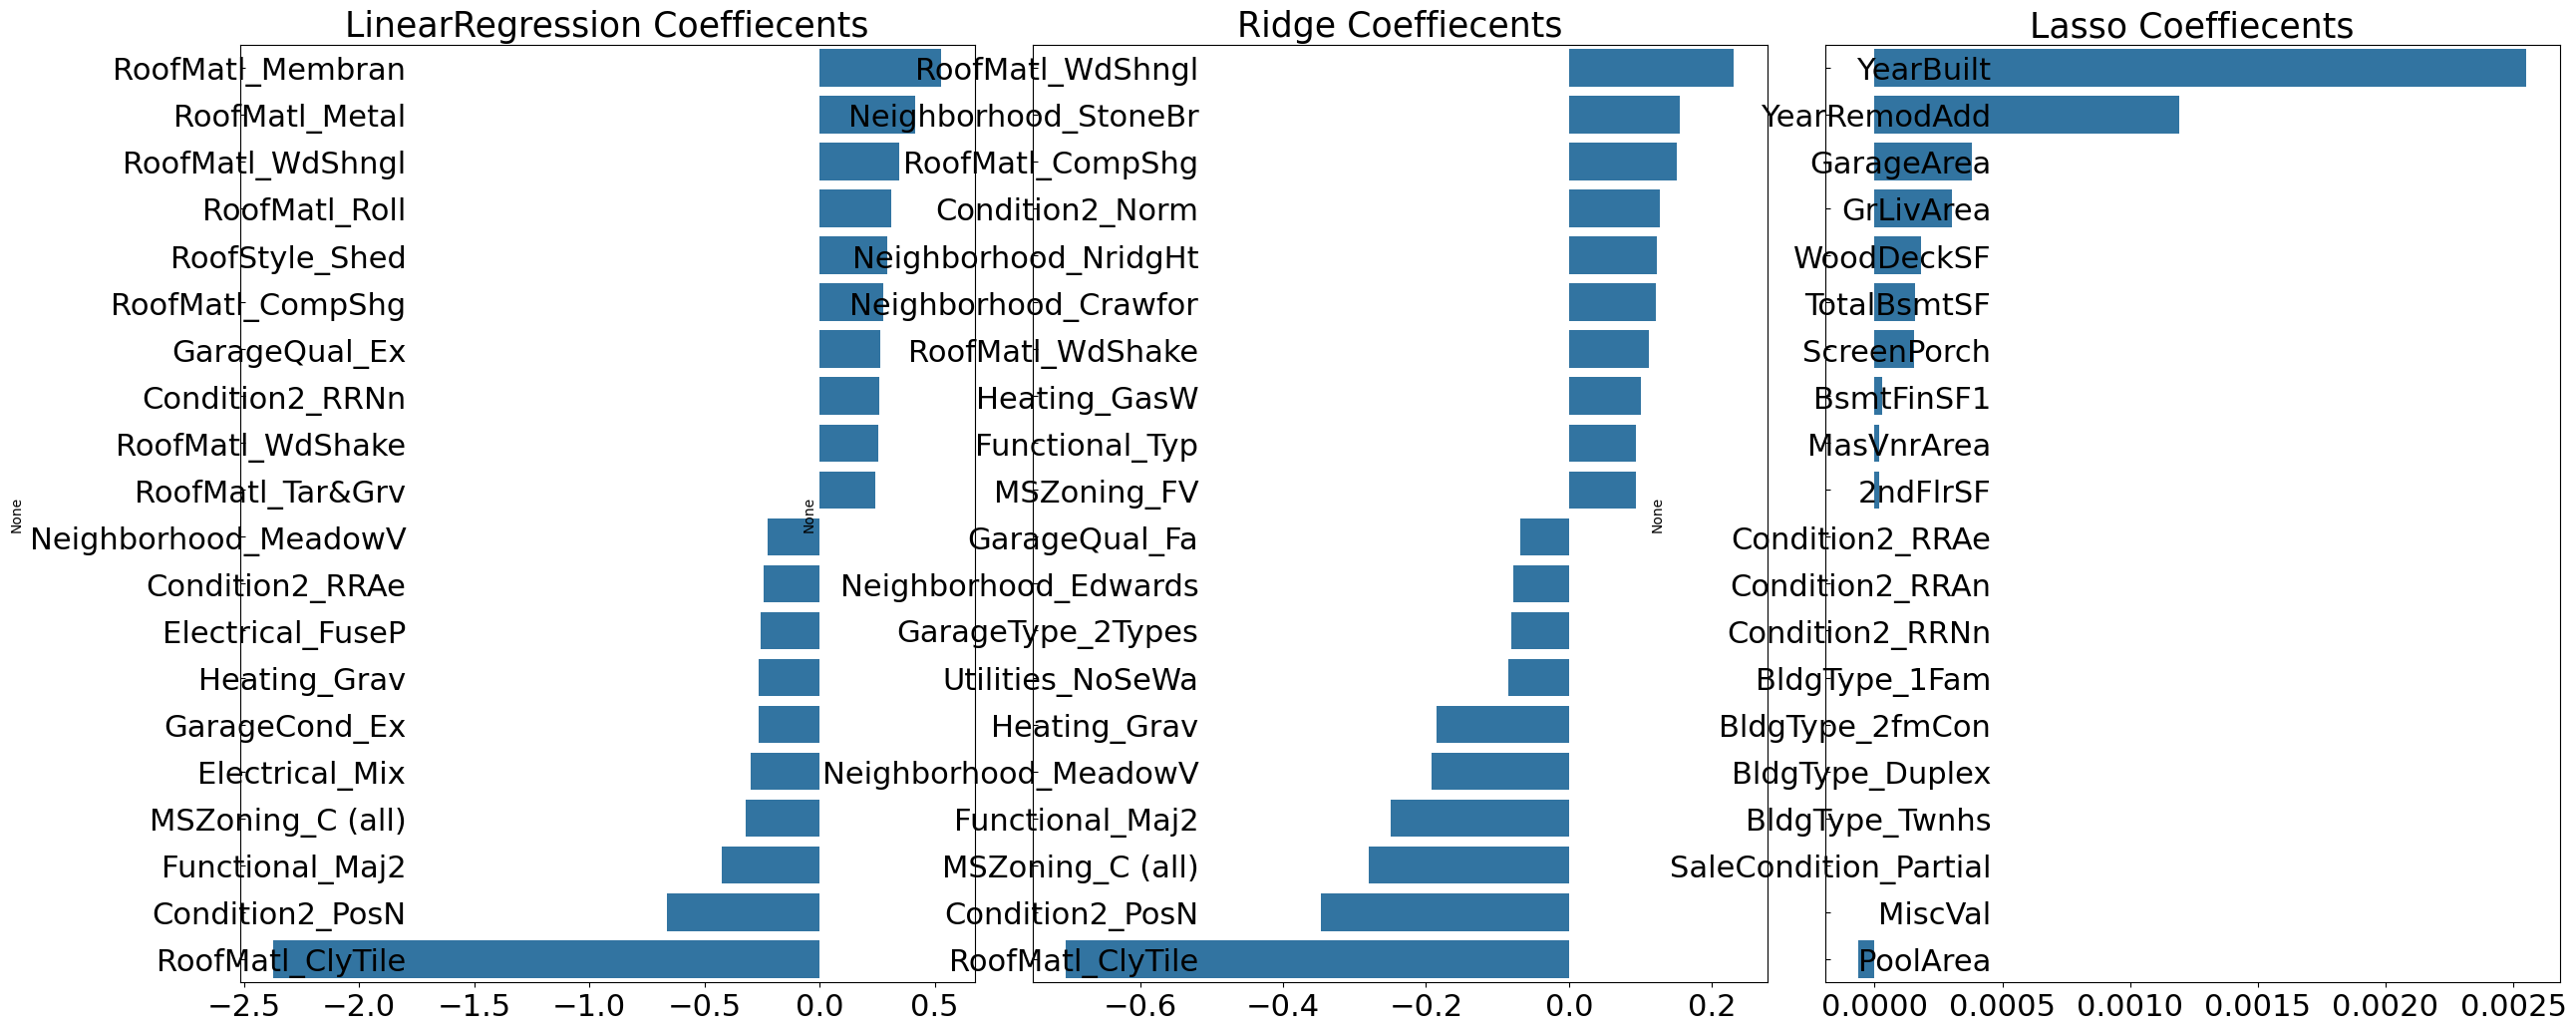

In [88]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [89]:
# 5개 교차 검증 폴드 세트로 분할 -> 평균 RMSE

In [90]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print(model.__class__.__name__, np.round(rmse_list, 3))
        print(model.__class__.__name__, np.round(rmse_avg, 3))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression [0.135 0.165 0.168 0.111 0.198]
LinearRegression 0.155
Ridge [0.117 0.154 0.142 0.117 0.189]
Ridge 0.144
Lasso [0.161 0.204 0.177 0.181 0.265]
Lasso 0.198


In [91]:
#  하이퍼 파라미터 조정 위한 함수

from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                               scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features,y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(model.__class__.__name__, np.round(rmse, 4),grid_model.best_params_)
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 0.1418 {'alpha': 12}
Lasso 0.142 {'alpha': 0.001}


LinearRegression 0.132
Ridge 0.124
Lasso 0.12


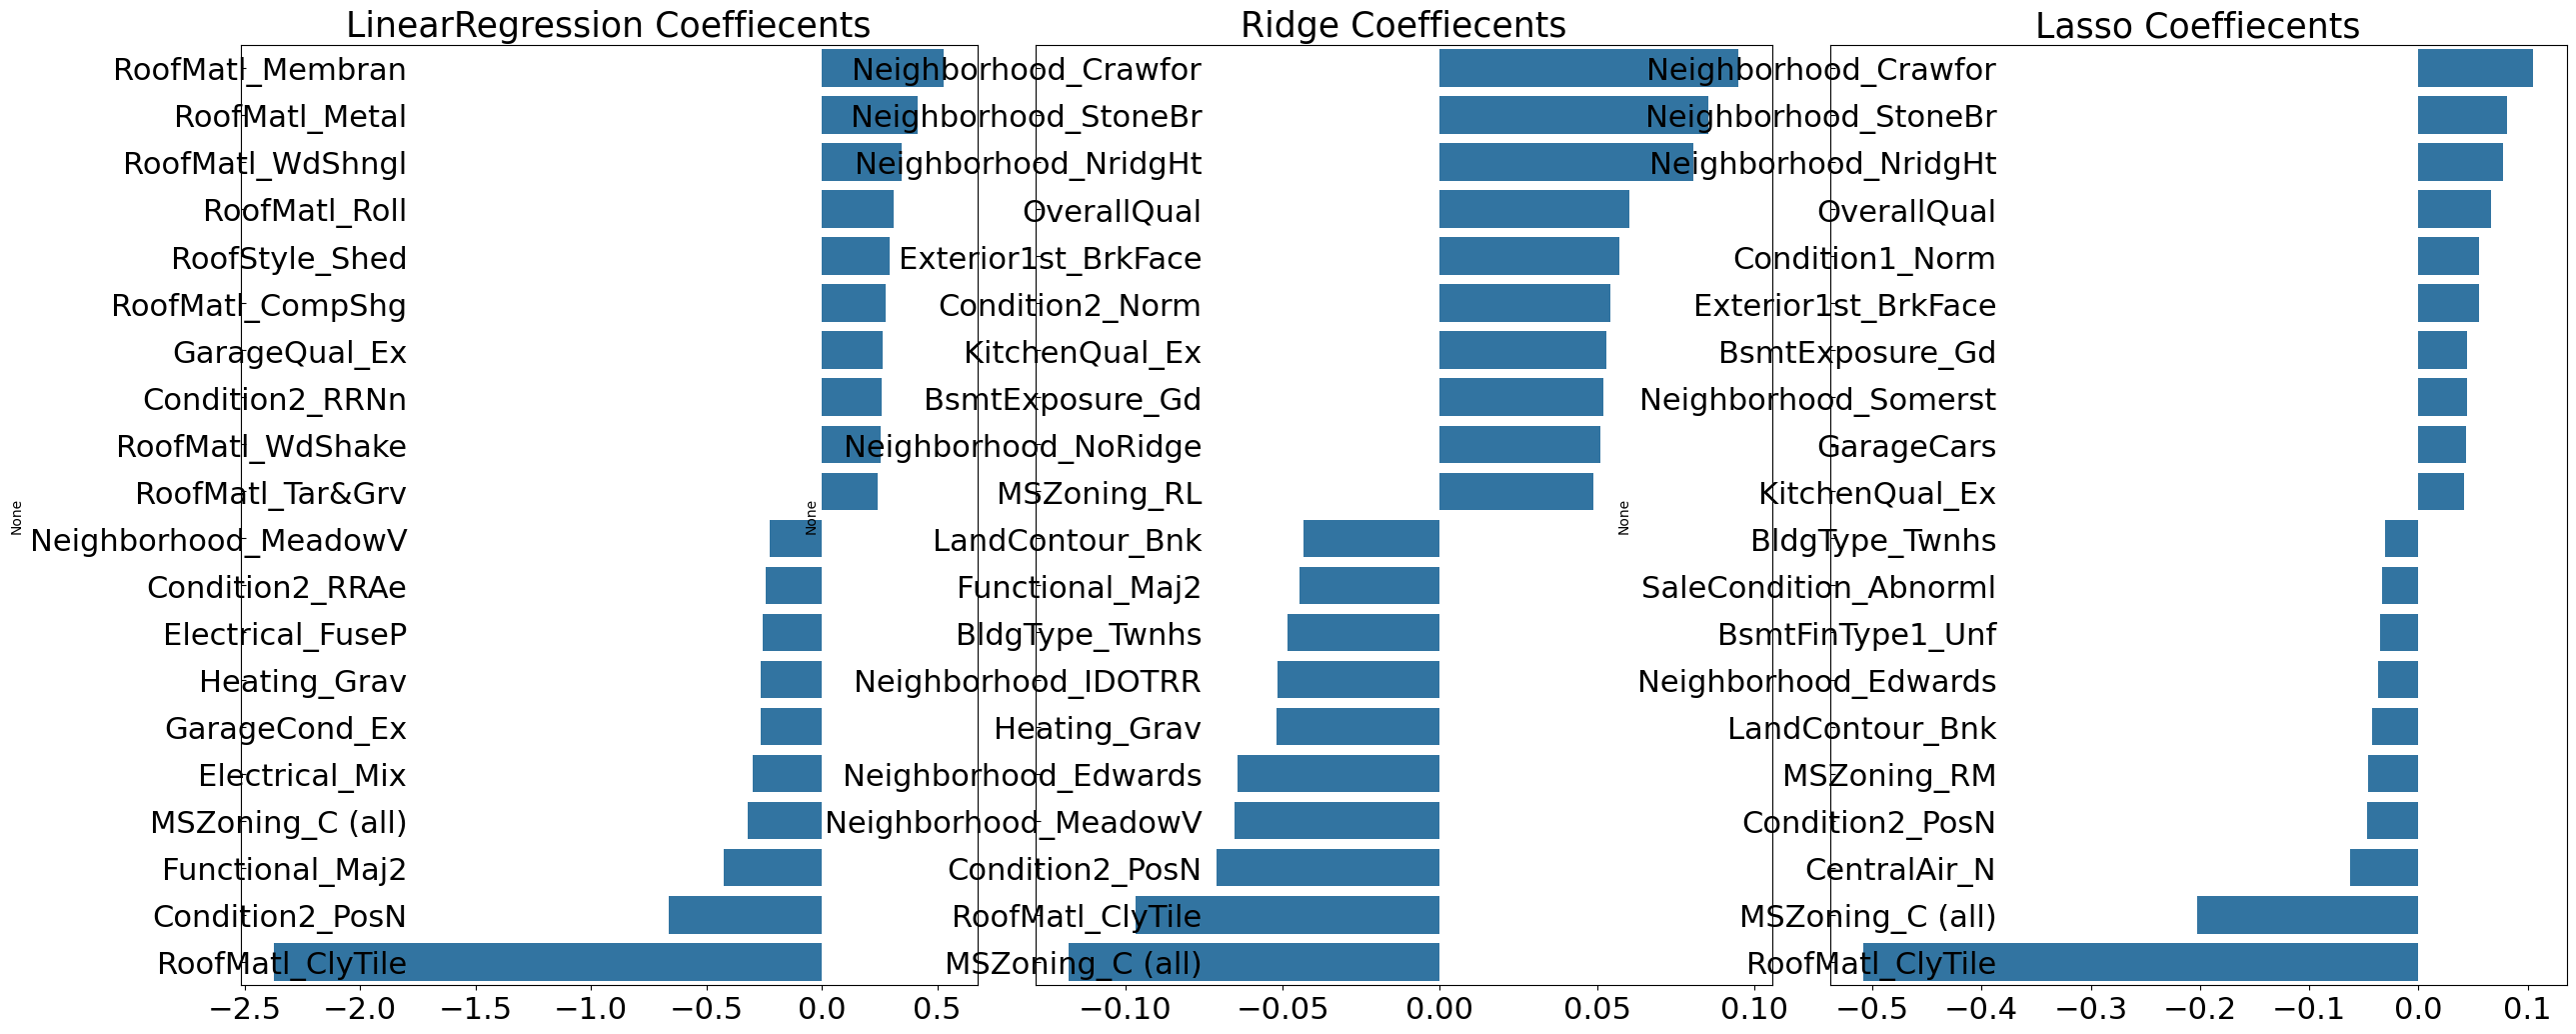

In [92]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [93]:
# 데이터 왜곡 로그 변환 후 성능 편가

In [94]:

from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [95]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])


In [96]:

# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 0.1275 {'alpha': 10}
Lasso 0.1252 {'alpha': 0.001}


In [97]:
Ridge 0.1418 {'alpha': 12}
Lasso 0.142 {'alpha': 0.001}

SyntaxError: invalid syntax (3420866855.py, line 1)

LinearRegression 0.128
Ridge 0.122
Lasso 0.119


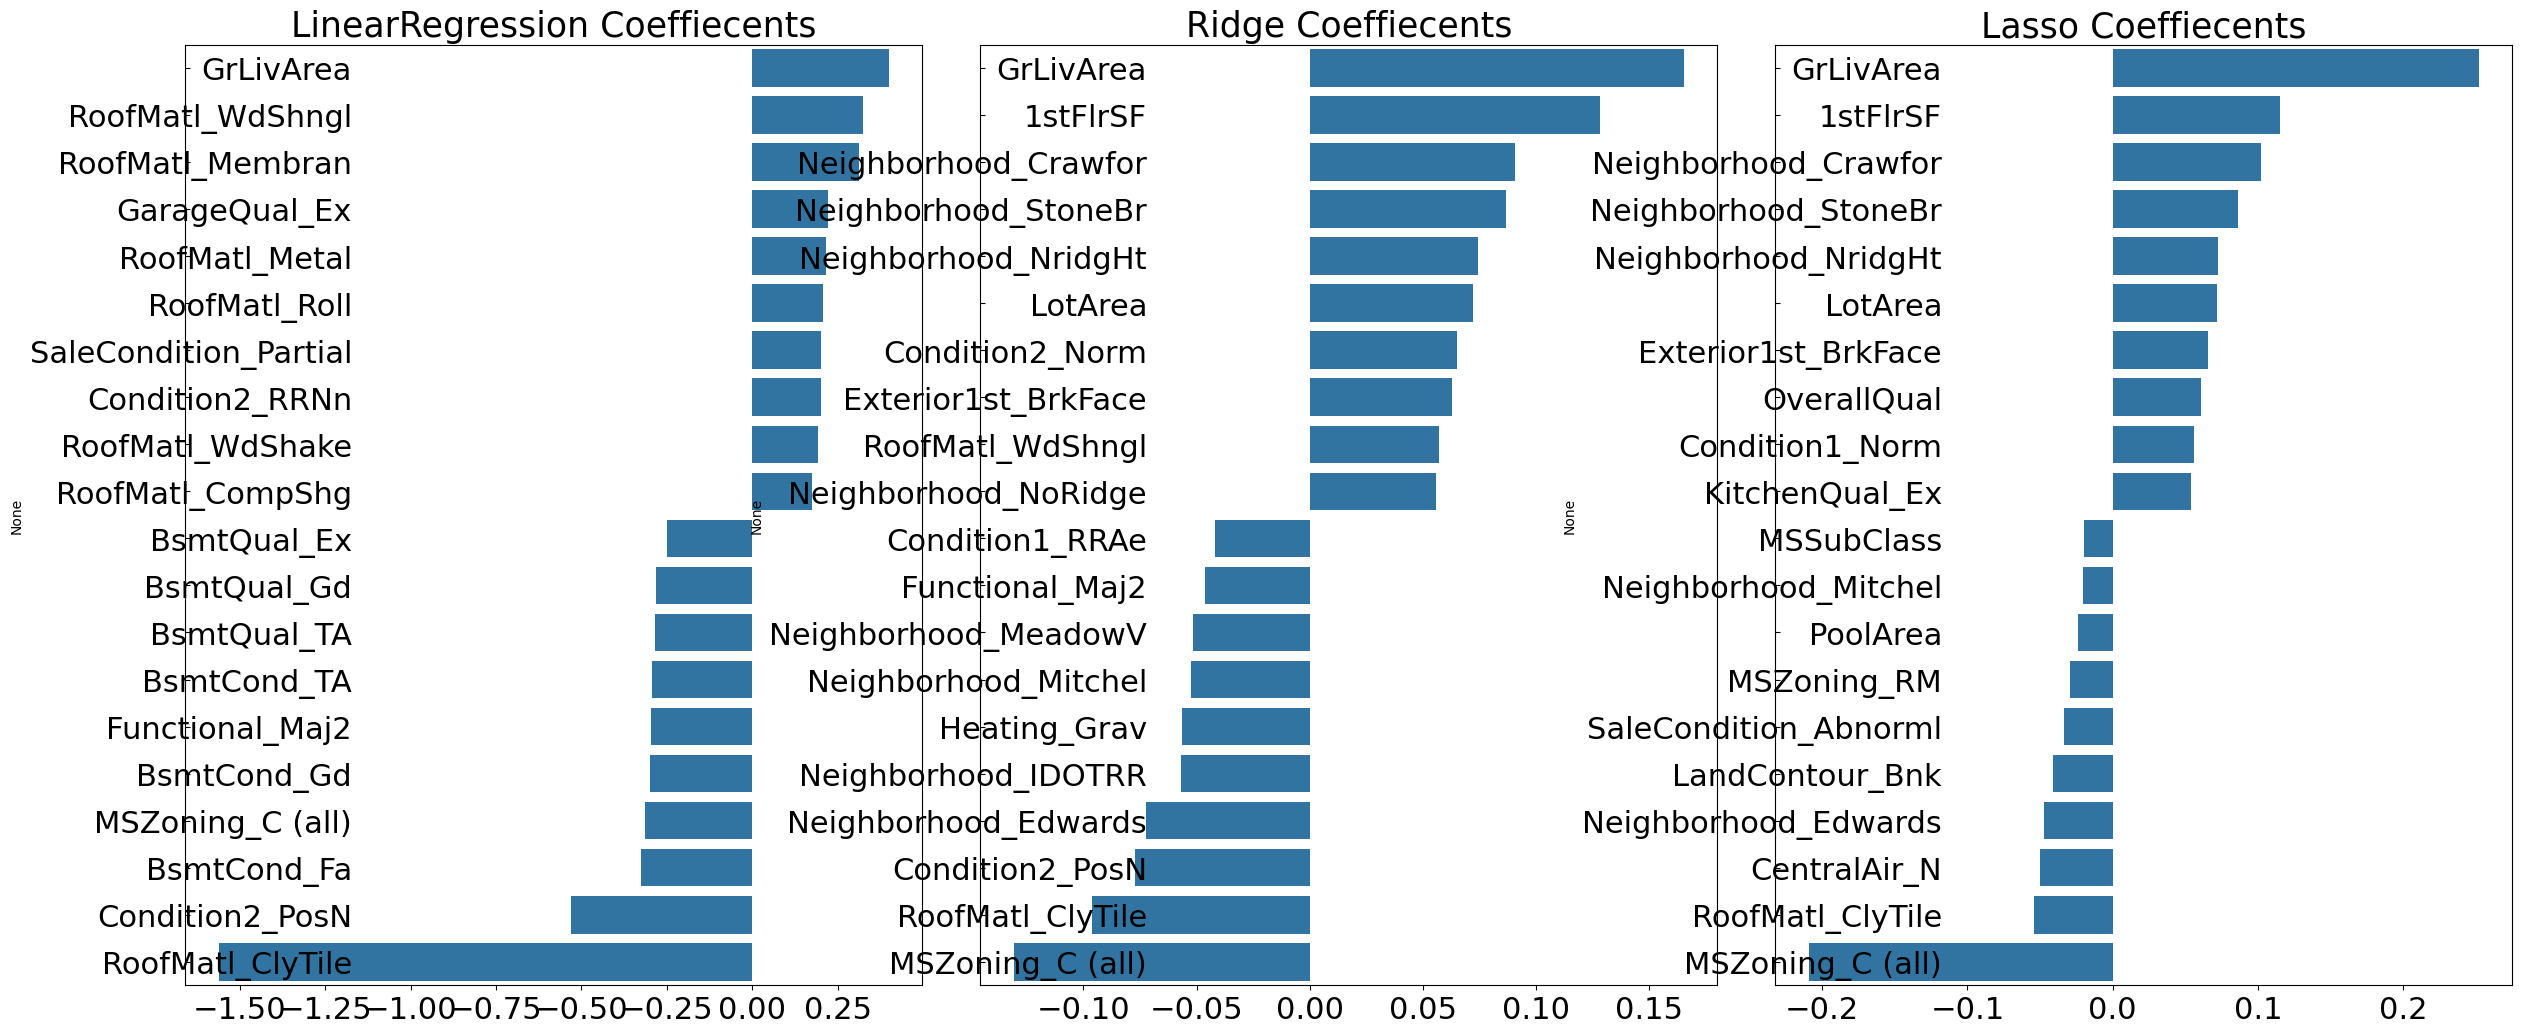

In [62]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 이상치 제거

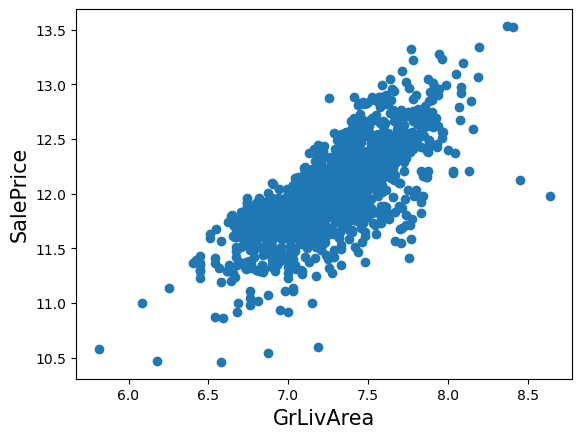

In [66]:
plt.scatter(x = house_df['GrLivArea'], y = house_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [69]:
# GrLivArea, SalePrice 양의 상관관계, 2개의 이상치 발견

In [67]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 271)


In [68]:
# 이상치 제거한 데이터로 릿지 라쏘 모델 최적화 수행 print_best_params()

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 0.1125 {'alpha': 8}
Lasso 0.1122 {'alpha': 0.001}


LinearRegression 0.129
Ridge 0.103
Lasso 0.1


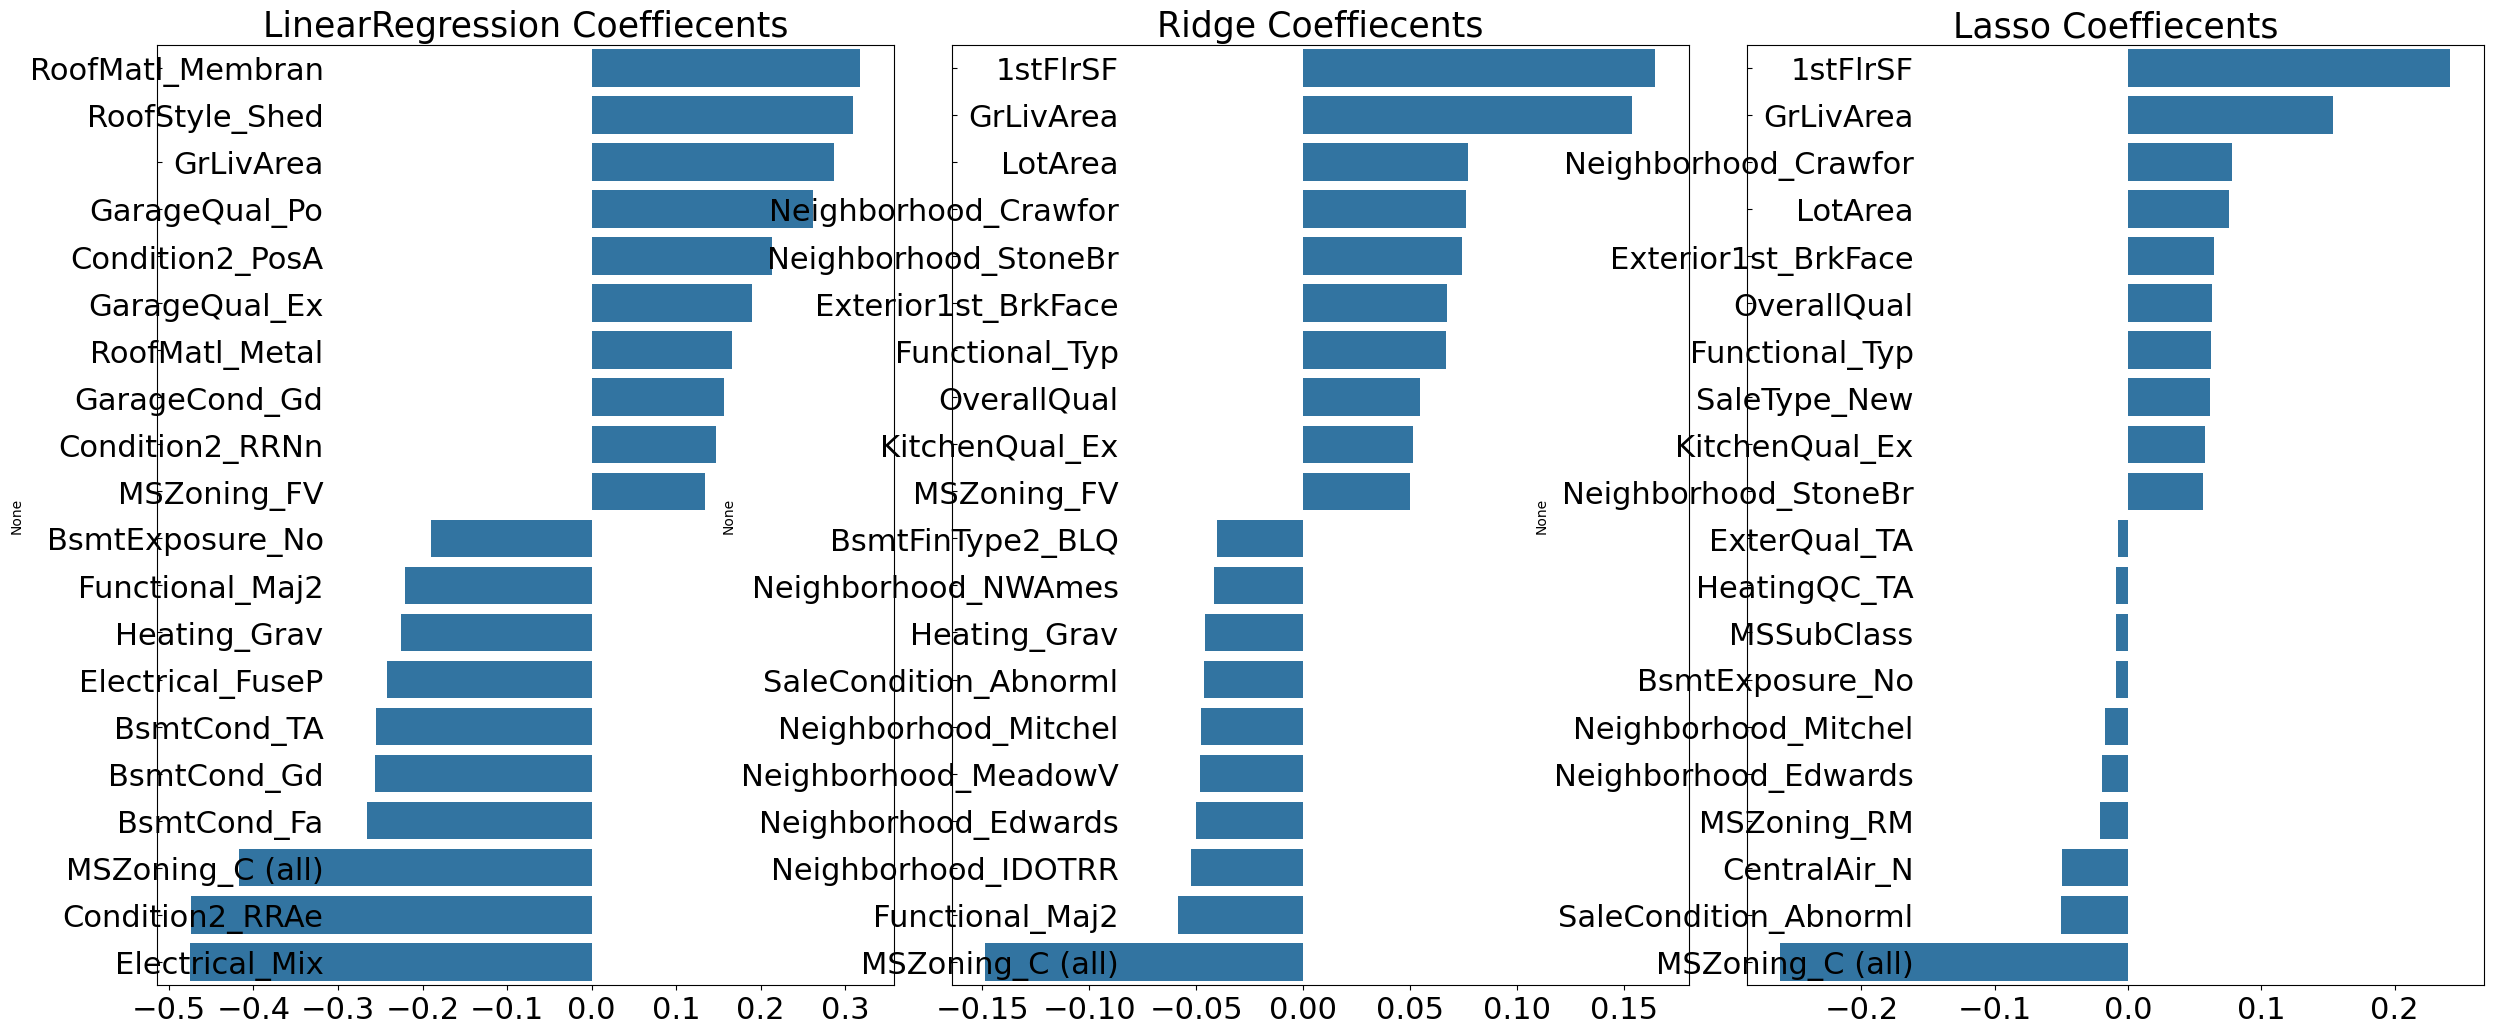

In [70]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)